# Kaggle Titanic: 3 - Modelling and Predictions

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import sys

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

from sklearn.model_selection import GridSearchCV, train_test_split
import shap

# Add the "src" directory to the system path
project_root  = os.path.abspath('../')

if project_root not in sys.path:
    sys.path.append(project_root)

from src.utils import PathManager, create_logistic_regression_pipeline, create_random_forest_pipeline, create_xgboost_pipeline, create_knn_pipeline
from src.project_specific import run_dm_pipeline


c:\Users\Florent\Documents\data_science\kaggle-titanic\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Working Environment

### Variables & Paths

In [2]:
path_manager = PathManager(dataset_name="titanic")
print("\n" + str(path_manager))

DATASET_PATH = path_manager.dataset_path
WORKING_PATH = path_manager.working_path

print(f"\nDATASET_PATH: {DATASET_PATH}")
print(f"WORKING_PATH: {WORKING_PATH}")

Running on local.
Dataset directory: c:\Users\Florent\Documents\data_science\kaggle-titanic\data
Working directory: c:\Users\Florent\Documents\data_science\kaggle-titanic\data\working

Dataset Path: c:\Users\Florent\Documents\data_science\kaggle-titanic\data
Working Path: c:\Users\Florent\Documents\data_science\kaggle-titanic\data\working

DATASET_PATH: c:\Users\Florent\Documents\data_science\kaggle-titanic\data
WORKING_PATH: c:\Users\Florent\Documents\data_science\kaggle-titanic\data\working


### Datasets

In [3]:
test = pd.read_csv(os.path.join(DATASET_PATH, "test.csv"))
train = pd.read_csv(os.path.join(DATASET_PATH, "train.csv"))

datasets_dict = {
    "train": train,
    "test": test
}

test_memory = test.memory_usage(deep=True).sum()
train_memory = train.memory_usage(deep=True).sum()
print(f"Test dataset memory usage: {test_memory / (1024**2):.2f} MB")
print(f"Train dataset memory usage: {train_memory / (1024**2):.2f} MB")

Test dataset memory usage: 0.13 MB
Train dataset memory usage: 0.28 MB


## Data Management

In [4]:
result = run_dm_pipeline(test, train)

categorical_features = result["categorical_features"]
numerical_features = result["numerical_features"]
target = result["target"]
test_ids = result["test_ids"]

Target Variable: Survived
Target Variable 'Survived' not found in DataFrame test.
'Embarked' is S for passenger at index 152. Imputing 'Fare' with median fare 8.05 for 'Pclass' 3 and 'Embarked' S.
Remaining missing 'Fare' values in test dataset: 0
Remaining missing 'Embarked' values in train dataset: 0
Remaining missing 'Age' values in the combined dataset: 0

Categorical_features: ['Pclass', 'Sex', 'Embarked', 'Simplified_Title', 'Deck', 'Is_Alone', 'AgeGroup']
Numerical features: ['Family_Size', 'LogFare']
target: Survived


In [5]:
test_df = result["test"][categorical_features + numerical_features]
train_df = result["train"][categorical_features + numerical_features + [target]]

Train - Test split

In [6]:
X = train_df[numerical_features + categorical_features]
y = train_df[target]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Modelling

### Model type selection

#### Pipelines

In [7]:
logreg_pipeline = create_logistic_regression_pipeline(
    numeric_features=numerical_features,
    categorical_features=categorical_features,
    C=0.5,
    random_state=42
)

In [8]:
rf_pipeline = create_random_forest_pipeline(
    numeric_features=numerical_features,
    categorical_features=categorical_features,
    n_estimators=200,
    max_depth=5,
    random_state=42
)

In [9]:
xgb_pipeline = create_xgboost_pipeline(
    numeric_features=numerical_features,
    categorical_features=categorical_features,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

In [10]:
knn_pipeline = create_knn_pipeline(
    numeric_features=numerical_features,
    categorical_features=categorical_features,
    n_neighbors=3
)

#### Fit

In [11]:
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Family_Size', 'LogFare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'Simplified_Title', 'Deck',
                                                   'Is_Alone', 'AgeGroup'])])),
                ('classifier',
                 LogisticRegression(C=0.5, max_iter=500, random_state=42))])

In [12]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Family_Size', 'LogFare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'Simplified_Title', 'Deck',
                                                   'Is_Alone', 'AgeGroup'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=5, n_estimators=200,
                                        random_state=42))])

In [13]:
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Family_Size', 'LogFare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Emba...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.05, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=4, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=200, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=42, reg_alpha=0,
                               reg_lambda=1, ...))])

In [14]:
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Family_Size', 'LogFare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'Simplified_Title', 'Deck',
                                                   'Is_Alone', 'AgeGroup'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=3))])

#### Predict and evaluate accuracy

Generate predictions:

In [15]:
logreg_preds = logreg_pipeline.predict(X_valid)
rf_preds = rf_pipeline.predict(X_valid)
xgb_preds = xgb_pipeline.predict(X_valid)
knn_preds = knn_pipeline.predict(X_valid)

print("Logistic Regression accuracy:", accuracy_score(y_valid, logreg_preds))
print("Random Forest accuracy:", accuracy_score(y_valid, rf_preds))
print("XGBoost accuracy:", accuracy_score(y_valid, xgb_preds))
print("kNN accuracy:", accuracy_score(y_valid, knn_preds))

Logistic Regression accuracy: 0.8324022346368715
Random Forest accuracy: 0.8156424581005587
XGBoost accuracy: 0.8379888268156425
kNN accuracy: 0.8044692737430168


Predicted probabilities for ROC AUC:

In [16]:
logreg_probs = logreg_pipeline.predict_proba(X_valid)[:, 1]
rf_probs = rf_pipeline.predict_proba(X_valid)[:, 1]
xgb_probs = xgb_pipeline.predict_proba(X_valid)[:, 1]
knn_probs = knn_pipeline.predict_proba(X_valid)[:, 1]

In [17]:
def evaluate_model(name, y_true, y_pred, y_proba=None):
    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    if y_proba is not None:
        print("ROC AUC Score:", roc_auc_score(y_true, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print()

Evaluate each model

In [18]:
evaluate_model("Logistic Regression", y_valid, logreg_preds, y_proba=logreg_probs)
evaluate_model("Random Forest", y_valid, rf_preds, y_proba=rf_probs)
evaluate_model("XGBoost", y_valid, xgb_preds, y_proba=xgb_probs)
evaluate_model("kNN", y_valid, knn_preds, y_proba=knn_probs)

--- Logistic Regression ---
Accuracy: 0.8324022346368715
Precision: 0.7972972972972973
Recall: 0.7972972972972973
F1 Score: 0.7972972972972973
ROC AUC Score: 0.8867438867438868
Confusion Matrix:
 [[90 15]
 [15 59]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.86      0.86       105
         1.0       0.80      0.80      0.80        74

    accuracy                           0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179


--- Random Forest ---
Accuracy: 0.8156424581005587
Precision: 0.8153846153846154
Recall: 0.7162162162162162
F1 Score: 0.762589928057554
ROC AUC Score: 0.8904761904761905
Confusion Matrix:
 [[93 12]
 [21 53]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.89      0.85       105
         1.0       0.82      0.72      0.76        74

    accuracy                         

Interpreting the Results

- Accuracy: Often the main metric on Kaggle for the Titanic dataset. Measures overall correctness.
- Precision & Recall: If you care more about not missing actual survivors, you’ll focus on recall. If you care more about only predicting “survived” when you’re certain, you’ll focus on precision.
- F1: Balances both precision and recall in one number.
- ROC AUC: If you want to see how well your model ranks positive vs. negative instances across all possible thresholds, look at AUC.
- Confusion Matrix: See exactly which class pairs are getting misclassified.

All these give you a broader picture of which model performs best for your specific objectives, not just raw accuracy. Depending on the goals, you might also consider:

- Cross-validation scores (to ensure your performance generalizes well).
- PR–AUC (Precision–Recall AUC) if your classes are heavily imbalanced (not the case in Titanic, but still can be informative).

In Kaggle’s Titanic competition, accuracy on the holdout set is typically used as the public leaderboard score, but for a more thorough understanding or for different business/real-world contexts, these additional metrics are highly recommended.

=> XGBoost seems to have the best metrics.

### XGBoost Hyperparameter Tuning

- n_estimators: Number of trees (iterations).
- max_depth: Maximum tree depth.
- learning_rate: Step size shrinkage.
- subsample: Fraction of samples used for each tree (stochastic gradient boosting).
- colsample_bytree: Fraction of features used for each tree.
- gamma: Minimum loss reduction required to make a further partition.
- reg_alpha / reg_lambda: L1/L2 regularization on weights.

In [19]:
# Parameter grid for GridSearchCV
param_grid = {
    # double underscore to access the XGBClassifier hyperparams
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [3, 5, 7],
    "classifier__learning_rate": [0.01, 0.1, 0.2],
    "classifier__subsample": [0.8, 1.0],
    "classifier__colsample_bytree": [0.8, 1.0]  # Optional, to try feature subsampling
}

#### Cross validation

Cross-validation helps get a more reliable estimate of out-of-sample performance for each hyperparameter setting. There are two main approaches in scikit-learn:

- GridSearchCV: Tries all combinations of parameter values (can be expensive with large grids).
- RandomizedSearchCV: Samples random combinations from given distributions (faster for large search spaces).

In [20]:
grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring="accuracy",   # or "f1", "precision", etc.
    cv=5,                 # 5-fold cross-validation
    n_jobs=-1,            # Use all CPU cores
    verbose=1             # Print progress
)

In [21]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Family_Size',
                                                                          'LogFare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignor...
                                                      n_estimators=200,
                                                      n_jobs=0,
                                                      num_parallel_tree=1,
                                                      predictor='auto',
                                                      random_state=42,
                                                      reg_alpha=0, reg_lambda=1, ...))]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.8, 1.0],
                         'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [100, 200, 300],
                         'classifier__subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [22]:
print("Best CV score:", grid_search.best_score_)
print("Best params:", grid_search.best_params_)

Best CV score: 0.8356938835812076
Best params: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


In [23]:
best_xgb_pipeline = grid_search.best_estimator_

#### Evaluation on the validation set

In [24]:
y_valid_pred = best_xgb_pipeline.predict(X_valid)

accuracy = accuracy_score(y_valid, y_valid_pred)
precision = precision_score(y_valid, y_valid_pred)
recall = recall_score(y_valid, y_valid_pred)
f1 = f1_score(y_valid, y_valid_pred)

print("Validation set metrics:")
print("Accuracy: ", accuracy)
print("Precision:", precision)
print("Recall:   ", recall)
print("F1 Score: ", f1)
print("\nDetailed Classification Report:\n", classification_report(y_valid, y_valid_pred))


Validation set metrics:
Accuracy:  0.8379888268156425
Precision: 0.8169014084507042
Recall:    0.7837837837837838
F1 Score:  0.8

Detailed Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.88      0.86       105
         1.0       0.82      0.78      0.80        74

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



#### Interpretability

Built-In Feature Importances

XGBoost provides feature importances directly via its scikit-learn wrapper (XGBClassifier.feature_importances_). However, these values:
- Are global importances.
- Typically reflect how many times (or how effectively) a feature was used to split across all trees.
- May not fully capture the nuanced interactions in boosted trees.

In [25]:
best_xgb_model = best_xgb_pipeline["classifier"]

importances = best_xgb_model.feature_importances_
print("Feature importances:", importances)

Feature importances: [0.03639935 0.02888351 0.01794531 0.19580375 0.2604879  0.02202552
 0.03053803 0.05388341 0.02238375 0.01740194 0.02139375 0.0223957
 0.03408716 0.         0.         0.         0.09376889 0.
 0.02641094 0.02974748 0.06053894 0.02590466]


##### SHAP values

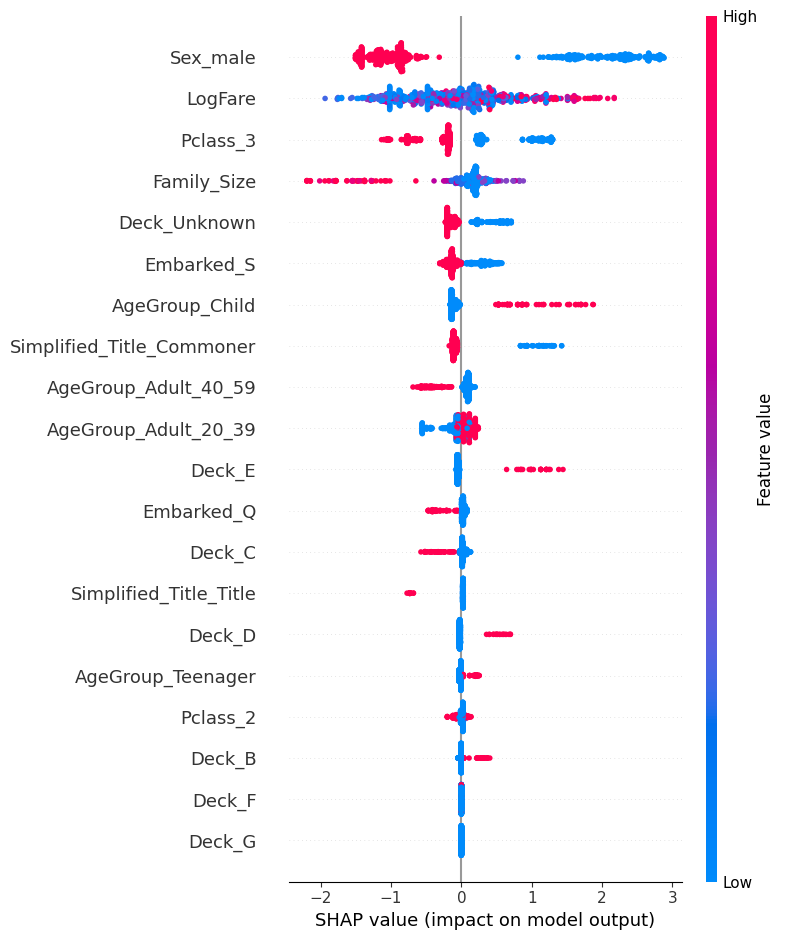

In [26]:
# Separate the trained pipeline steps: preprocessor vs. classifier
best_pipeline = grid_search.best_estimator_
preprocessor = best_pipeline["preprocessor"]
xgb_model = best_pipeline["classifier"]  # This is the XGBClassifier

# Transform the training data using the preprocessor
#    so we get the exact numeric matrix that XGBClassifier sees.
X_train_transformed = preprocessor.transform(X_train)

# Create a SHAP Explainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_transformed)

# Add features names: 
cat_ohe = preprocessor.named_transformers_["cat"]["onehot"]  
cat_feature_names = cat_ohe.get_feature_names_out(input_features=categorical_features)
# numeric_features remains the same, except for any dropped columns, so it’s straightforward:
num_feature_names = numerical_features
# Combine them (ColumnTransformer order is [num, cat])
all_transformed_feature_names = list(num_feature_names) + list(cat_feature_names)

shap.summary_plot(shap_values, X_train_transformed, feature_names=all_transformed_feature_names)

## Kaggle submission

In [27]:
X_test = test_df[numerical_features + categorical_features]
test_preds = best_xgb_pipeline.predict(X_test)

In [28]:
submission = pd.DataFrame({"PassengerId": test_ids, "Survived": test_preds})
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [ ]:
# submission.to_csv("submission.csv", index=False)